In [1]:
%matplotlib inline

/home/mr243268/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Manipulating brain image volumes

## Outline

### 1. Data preparation and transformation

Nilearn has many **simple functions** for data preparation and transformation. Most are also integrated in the **masker objects**.


- Computing the mean of images (along the time/4th dimension): **`nilearn.image.mean_img`**


- Applying numpy functions on an image or a list of images: **`nilearn.image.math_img`**


- Swapping voxels of both hemisphere (e.g., useful to homogenize masks inter-hemispherically): **`nilearn.image.swap_img_hemispheres`**


- Smoothing: **`nilearn.image.smooth_img`**


- Cleaning signals (e.g., linear detrending, standardization, confound removal, low/high pass filtering): **`nilearn.image.clean_img`**


- Resampling : **`nilearn.image.resample_img`** or **`nilearn.image.resample_to_img`**


**Note:** To apply this cleaning on signal matrices rather than images: **`nilearn.signal.clean`**


### 2. Image masking


- Voxel level.


- ROI level.


- Seed level.


- # Smoothing

We smooth a **mean epi image**, with a varying amount of smoothing, from **none to 20mm by steps of 10mm**.

First subject functional nifti image (4D) are located at: /home/mr243268/data/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


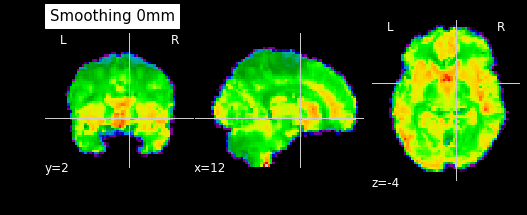

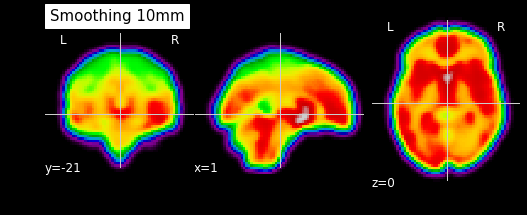

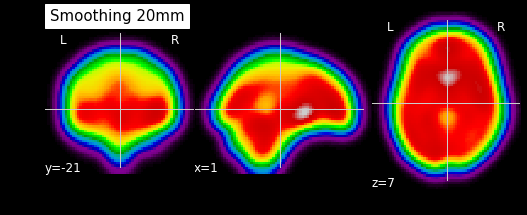

In [10]:
from nilearn import datasets, plotting, image

data = datasets.fetch_adhd(n_subjects=1)

# Print basic information on the dataset
print('First subject functional nifti image (4D) are located at: %s' %
      data.func[0])

first_epi_file = data.func[0]

# First the compute the mean image, from the 4D series of image
mean_func = image.mean_img(first_epi_file)

# Then we smooth, with a varying amount of smoothing, from none to 20mm
# by increments of 10mm
for smoothing in range(0, 30, 10):
    smoothed_img = image.smooth_img(mean_func, smoothing)
    plotting.plot_epi(smoothed_img,
                      title="Smoothing %imm" % smoothing)

- # Resampling an image to a template

We use **`nilearn.image.resample_to_img`** to resample an image to a template.

We use the MNI152 template as the reference for resampling a t-map image.

**`nilearn.image.resample_img`** could also be used to achieve this.



- We load the required datasets.



In [5]:
# First we load the required datasets using the nilearn datasets module.
from nilearn.datasets import fetch_localizer_button_task
from nilearn.datasets import load_mni152_template

template = load_mni152_template()

localizer_dataset = fetch_localizer_button_task(get_anats=True)

localizer_tmap_filename = localizer_dataset.tmaps[0]
localizer_anat_filename = localizer_dataset.anats[0]

- The localizer t-map image is resampled to the MNI template image


In [6]:
# Now, the localizer t-map image can be resampled to the MNI template image.
from nilearn.image import resample_to_img

resampled_localizer_tmap = resample_to_img(localizer_tmap_filename, template)

- Now we check the shape and affine have been correctly updated.


In [7]:
# Let's check the shape and affine have been correctly updated.

# First load the original t-map in memory:
from nilearn.image import load_img
tmap_img = load_img(localizer_dataset.tmaps[0])

original_shape = tmap_img.shape
original_affine = tmap_img.get_affine()

resampled_shape = resampled_localizer_tmap.shape
resampled_affine = resampled_localizer_tmap.get_affine()

template_img = load_img(template)
template_shape = template_img.shape
template_affine = template_img.get_affine()
print("""Shape comparison:
- Original t-map image shape : {0}
- Resampled t-map image shape: {1}
- Template image shape       : {2}
""".format(original_shape, resampled_shape, template_shape))

print("""Affine comparison:
- Original t-map image affine :\n {0}
- Resampled t-map image affine:\n {1}
- Template image affine       :\n {2}
""".format(original_affine, resampled_affine, template_affine))

Shape comparison:
- Original t-map image shape : (53, 63, 46)
- Resampled t-map image shape: (91, 109, 91)
- Template image shape       : (91, 109, 91)

Affine comparison:
- Original t-map image affine :
 [[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
- Resampled t-map image affine:
 [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
- Template image affine       :
 [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]



- Result images are displayed using nilearn plotting module.

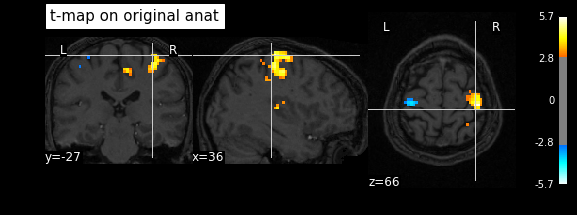

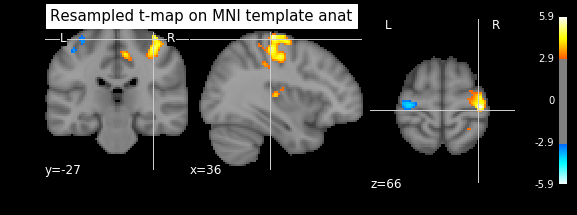

In [8]:
# Finally, result images are displayed using nilearn plotting module.
from nilearn import plotting

plotting.plot_stat_map(localizer_tmap_filename,
                       bg_img=localizer_anat_filename,
                       cut_coords=(36, -27, 66),
                       threshold=3,
                       title="t-map on original anat")
plotting.plot_stat_map(resampled_localizer_tmap,
                       bg_img=template,
                       cut_coords=(36, -27, 66),
                       threshold=3,
                       title="Resampled t-map on MNI template anat")

- # Masking

**What is it ?**

![masking](figures/masking.jpg)

- # Masking voxels with `NiftiMasker`

Here is a simple example of automatic mask computation using the nifti masker.
The mask is computed and visualized.

- First we fetch the data to be masked. 

In [11]:
# Retrieve the ADHD dataset

from nilearn import datasets
dataset = datasets.fetch_adhd(n_subjects=1)
func_filename = dataset.func[0]

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' % func_filename)


First functional nifti image (4D) is at: /home/mr243268/data/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


- We compute the mask.

In [12]:
# Compute the mask
from nilearn.input_data import NiftiMasker

# As this is raw resting-state EPI, the background is noisy and we cannot
# rely on the 'background' masking strategy. We need to use the 'epi' one
nifti_masker = NiftiMasker(standardize=True, mask_strategy='epi',
                           memory="nilearn_cache", memory_level=2,
                           smoothing_fwhm=8)
nifti_masker.fit(func_filename)
mask_img = nifti_masker.mask_img_


- We visualize the mask

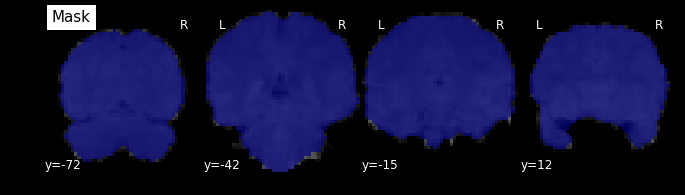

In [13]:
# Visualize the mask
from nilearn import plotting
from nilearn.image.image import mean_img

# calculate mean image for the background
mean_func_img = mean_img(func_filename)

plotting.plot_roi(mask_img, mean_func_img, display_mode='y', cut_coords=4, title="Mask")


- # Masking labels with `NiftiLabelsMasker`

We use the AAL atlas in this example.

- We fetch the needed **fMRI** and the **AAL atlas**.

In [16]:
# Retrieve the ADHD dataset

from nilearn import datasets
dataset = datasets.fetch_adhd(n_subjects=1)
func_filename = dataset.func[0]

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' % func_filename)

# fetch 
aal = datasets.fetch_atlas_aal()
aal_atlas = aal['maps']
print('AAL atlas is at: %s' % aal_atlas)



First functional nifti image (4D) is at: /home/mr243268/data/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
AAL atlas is at: /home/mr243268/data/nilearn_data/aal_SPM12/aal/atlas/AAL.nii


- We extract timeseries for each ROI of AAL atlas.

In [17]:
from nilearn.input_data import NiftiLabelsMasker 

# Label masker
nifti_labels_masker = NiftiLabelsMasker(
    labels_img=aal_atlas,
    standardize=True,
    memory="nilearn_cache", memory_level=2)

# extract timeseries
timeseries = nifti_labels_masker.fit_transform(func_filename)


/home/mr243268/dev/modules/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


- Now, we visualize the AAL atlas and check the extracted timeseries dimension.

Timeseries dimension is:
(176, 116)


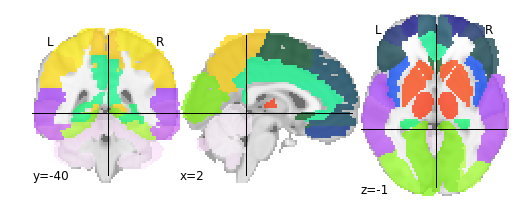

In [27]:
# Visualize the mask
from nilearn import plotting

plotting.plot_roi(aal_atlas)

# we should have ROIs per timeseries
print('Timeseries dimension is:')
print(timeseries.shape)

- # Masking seeds with `NiftiSpheresMasker`

This example shows how to extract timeseries from seeds for a single
subject based on resting-state fMRI scans.
We need :
- Seeds (coordinates)
- 4D Nifti image

In [28]:
# Getting the data
# ----------------

# We will work with the first subject of the adhd data set.
# adhd_dataset.func is a list of filenames. We select the 1st (0-based)
# subject by indexing with [0]).
from nilearn import datasets

adhd_dataset = datasets.fetch_adhd(n_subjects=1)
func_filename = adhd_dataset.func[0]
confound_filename = adhd_dataset.confounds[0]

##########################################################################
# Note that func_filename and confound_filename are strings pointing to
# files on your hard drive.
print(func_filename)
print(confound_filename)



/home/mr243268/data/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
/home/mr243268/data/nilearn_data/adhd/data/0010042/0010042_regressors.csv


- We select one seed in the PCC of 8mm radius that will be used to extract the averaged timeseries.
- Timeseries are detrended, standardized and bandpass filtered.

In [29]:
# We will be working with one seed sphere in the Posterior Cingulate Cortex,
# considered part of the Default Mode Network.
pcc_coords = [(0, -52, 18)]

from nilearn import input_data

##########################################################################
# We use `nilearn.input_data.NiftiSpheresMasker` to extract the
# **time series from the functional imaging within the sphere**. The
# sphere is centered at pcc_coords and will have the radius we pass the
# NiftiSpheresMasker function (here 8 mm).
#
# The extraction will also detrend, standardize, and bandpass filter the data.
# This will create a NiftiSpheresMasker object.

seed_masker = input_data.NiftiSpheresMasker(
    pcc_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0)


- Then we extract the mean time series within the seed region while regressing out the confounds that can be found in the dataset's csv file.


In [30]:
# Then we extract the mean time series within the seed region while
# regressing out the confounds that
# can be found in the dataset's csv file
seed_time_series = seed_masker.fit_transform(func_filename,
                                             confounds=[confound_filename])

##########################################################################
# We can now inspect the extracted time series. Note that the **seed time
# series** is an array with shape n_volumes, 1), while the
# **brain time series** is an array with shape (n_volumes, n_voxels).

print("seed time series shape: (%s, %s)" % seed_time_series.shape)

seed time series shape: (176, 1)


- We can plot the **seed time series**.

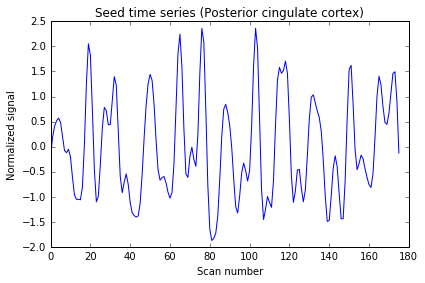

In [31]:
# We can plot the **seed time series**.

import matplotlib.pyplot as plt

plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()


- # Region Extraction from a t-statistical map (3D)

This example shows how to extract regions or separate the regions
from a statistical map.

We use localizer t-statistic maps from :func:`nilearn.datasets.fetch_localizer_contrasts`
as an input image.

The idea is to threshold an image to get foreground objects using a
function `nilearn.image.threshold_img` and extract objects using a function
`nilearn.regions.connected_regions`.

In [36]:
# Fetching t-statistic image of localizer constrasts by loading from datasets
# utilities
from nilearn import datasets

n_subjects = 3
localizer_path = datasets.fetch_localizer_contrasts(
    ['calculation (auditory cue)'], n_subjects=n_subjects, get_tmaps=True)
tmap_filename = localizer_path.tmaps[0]


- Threshold the t-statistic image by importing threshold function.

In [37]:
# Threshold the t-statistic image by importing threshold function
from nilearn.image import threshold_img

# Two types of strategies can be used from this threshold function
# Type 1: strategy used will be based on scoreatpercentile
threshold_percentile_img = threshold_img(tmap_filename, threshold='97%')


# Type 2: threshold strategy used will be based on image intensity
# Here, threshold value should be within the limits i.e. less than max value.
threshold_value_img = threshold_img(tmap_filename, threshold=4.)


- Show thresholding results

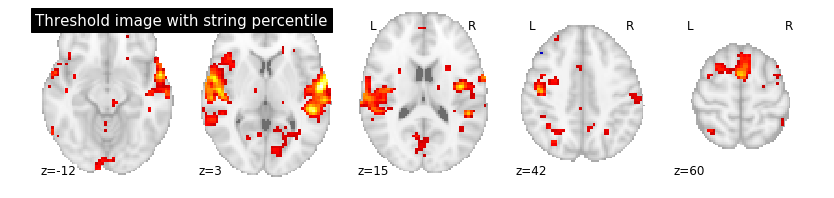

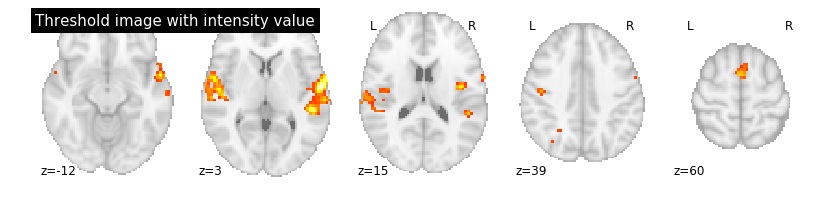

In [38]:
# Visualization
# Showing thresholding results by importing plotting modules and its utilities
from nilearn import plotting

# Showing percentile threshold image
plotting.plot_stat_map(threshold_percentile_img, display_mode='z', cut_coords=5,
                       title='Threshold image with string percentile', colorbar=False)

# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, display_mode='z', cut_coords=5,
                       title='Threshold image with intensity value', colorbar=False)


- Extract the regions by importing connected regions function

In [39]:
# Extracting the regions by importing connected regions function
from nilearn.regions import connected_regions

regions_percentile_img, index = connected_regions(threshold_percentile_img,
                                                  min_region_size=1500)

regions_value_img, index = connected_regions(threshold_value_img,
                                             min_region_size=1500)


- Visualize region extraction results

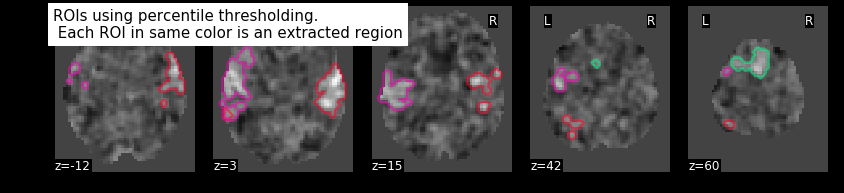

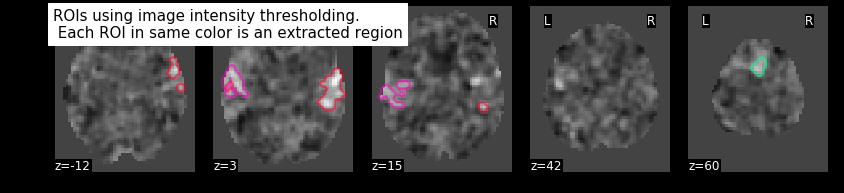

In [41]:
# Visualizing region extraction results
title = ("ROIs using percentile thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_percentile_img, anat_img=tmap_filename,
                         view_type='contours', display_mode='z',
                         cut_coords=5, title=title)
title = ("ROIs using image intensity thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_value_img, anat_img=tmap_filename,
                         view_type='contours', display_mode='z',
                         cut_coords=5, title=title)